# Exploration et comprehension des données 

**Importation des modules necessaires**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from sklearn.ensemble import HistGradientBoostingClassifier

**Importation des données**

In [2]:
# Données generales sur les employés
emp_inf = pd.read_csv('general_data.csv')

# Données fournies par les manager
emp_man = pd.read_csv('manager_survey_data.csv')

# Donnees d'evaluation des employers
emp_eval = pd.read_csv('employee_survey_data.csv')

#Worktime( à pourvoir)
emp_time_in = pd.read_csv('in_time.csv')
emp_time_out = pd.read_csv('out_time.csv')


In [3]:
emp_inf.head(5)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


**Fusionnons l'ensemble de nos données (general, Employee_Survey and Manager survey data) en un dataset nomme emp_glob**

In [4]:

# Merging datasets for general data and Employee Survey
emp1 = pd.merge(emp_inf,emp_eval, on=['EmployeeID'],how='inner')
# Merging the resultant dataset with Manager survey data
emp_glob = pd.merge(emp1,emp_man, on=['EmployeeID'],how='inner')

emp_glob.shape

(4410, 29)

In [5]:
# Nouvelle liste de noms
nouveaux_noms = ["EmployeeID"] + [f"Jour_de_travail_{i}" for i in range(1, len(emp_time_in.columns))]  # Générer 262 nouveaux noms
emp_time_in.columns = nouveaux_noms
emp_time_out.columns = nouveaux_noms
emp_time_in.head(2)

,EmployeeID,Jour_de_travail_1,Jour_de_travail_2,Jour_de_travail_3,Jour_de_travail_4,Jour_de_travail_5,Jour_de_travail_6,Jour_de_travail_7,Jour_de_travail_8,Jour_de_travail_9,...,Jour_de_travail_252,Jour_de_travail_253,Jour_de_travail_254,Jour_de_travail_255,Jour_de_travail_256,Jour_de_travail_257,Jour_de_travail_258,Jour_de_travail_259,Jour_de_travail_260,Jour_de_travail_261
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20


**_Transformation de nos datas relatifs aux heures(depart et arrivée) de travail:_**

In [6]:
# Transposer notre Dataframe
intime_T = emp_time_in.T

# Vérifiez le nombre de valeurs nulles dans chaque colonne: intime_T.isnull().sum().values 
# Observation : le nombre de valeurs nulles est assez faible, il est possible de les remplir
# Pour chaque salarié, définir une valeur en fonction de son mode de présence:
for employee in intime_T:
    value_to_fill = intime_T[employee].value_counts().sort_values(ascending=False).index[1]
    intime_T[employee] = intime_T[employee].fillna(value_to_fill)

    datetime_data = pd.to_datetime(intime_T[employee]) # convert to datetime dtype
    hour_data = datetime_data.dt.strftime('%H').apply(lambda x: int(x)) # get current hour, convert to integer
    min_data = datetime_data.dt.strftime('%M').apply(lambda x: int(x)) # get current minute, convert to integer
    data_to_return = hour_data * 60 + min_data # get current minute in day
    intime_T[employee] = data_to_return # updatee the column 

outime_T = emp_time_out.T

# Vérifiez le nombre de valeurs nulles dans chaque colonne: intime_T.isnull().sum().values 
# Observation : le nombre de valeurs nulles est assez faible, il est possible de les remplir

# For each employee, fillna value according to the mode of their in-time
for employee in outime_T:
    value_to_fill = outime_T[employee].value_counts().sort_values(ascending=False).index[1]
    outime_T[employee] = outime_T[employee].fillna(value_to_fill)

    datetime_data = pd.to_datetime(outime_T[employee]) # convert to datetime dtype
    hour_data = datetime_data.dt.strftime('%H').apply(lambda x: int(x)) # get current hour, convert to integer
    min_data = datetime_data.dt.strftime('%M').apply(lambda x: int(x)) # get current minute, convert to integer
    data_to_return = hour_data * 60 + min_data # get current minute in day
    outime_T[employee] = data_to_return # updatee the column 

In [7]:
office_time_spent = outime_T - intime_T # get the time spent
office_time_spent = office_time_spent.iloc[1:,:] # delete the employeeID row
agg_time_spent = pd.DataFrame(office_time_spent.T.mean(axis=1),columns=['Time_spent']) # get the mean of time spent
agg_time_spent = agg_time_spent.rename(columns={"Unnamed: 0": "EmployeeID"})
agg_time_spent.head(5)

,Time_spent
0,441.398467
1,465.356322
2,419.440613
3,432.444444
4,480.536398


In [8]:
# Ratio dataframe
gen_data_new = pd.concat([emp_glob,agg_time_spent],axis=1)
gen_data_new.head(10)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Time_spent
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3.0,4.0,2.0,3,3,441.398467
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,3.0,2.0,4.0,2,4,465.356322
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,2.0,2.0,1.0,3,3,419.440613
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,4.0,4.0,3.0,2,3,432.444444
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,4.0,1.0,3.0,3,3,480.536398
5,46,No,Travel_Rarely,Research & Development,8,3,Life Sciences,1,6,Female,...,5,7,7,7,3.0,2.0,2.0,3,3,647.601533
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,1,7,Male,...,2,0,0,0,1.0,3.0,1.0,3,4,414.785441
7,29,No,Travel_Rarely,Research & Development,18,3,Life Sciences,1,8,Male,...,2,0,0,0,1.0,2.0,3.0,3,4,405.011494
8,31,No,Travel_Rarely,Research & Development,1,3,Life Sciences,1,9,Male,...,2,9,7,8,2.0,4.0,3.0,3,4,432.406130
9,25,No,Non-Travel,Research & Development,7,4,Medical,1,10,Female,...,2,6,1,5,2.0,1.0,3.0,3,3,426.559387


**Regroupons les colonnes contenant des donnees de type numerique et celles des donnees de type categorielle dans des variables:**

In [9]:
numerical_data = gen_data_new.select_dtypes(include = ['int64', 'float']).columns
categorical_data = gen_data_new.select_dtypes(include = ['object']).columns

**Verifions ensuite si notre Dataset ne contienne pas de valeurs manquantes ou nulles :**

In [10]:
gen_data_new.isnull().sum().sort_values(ascending = False)

WorkLifeBalance            38
EnvironmentSatisfaction    25
JobSatisfaction            20
NumCompaniesWorked         19
TotalWorkingYears           9
Age                         0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
MonthlyIncome               0
MaritalStatus               0
JobRole                     0
JobLevel                    0
Gender                      0
StandardHours               0
PercentSalaryHike           0
Over18                      0
YearsAtCompany              0
TrainingTimesLastYear       0
StockOptionLevel            0
YearsWithCurrManager        0
YearsSinceLastPromotion     0
JobInvolvement              0
PerformanceRating           0
Time_spent                  0
dtype: int64

Les colonnes *_WorkLifeBalance_*, *_EnvironmentSatisfaction_*, *_JobSatisfaction_* et *_NumCompaniesWorked_*, *_TotalWorkingYears_*  de notre dataset contiennent des **valeurs nulles**, il sera dont question pour nous  de remplacer ces valeurs manquantes en utilisant par exemple la **mediane de la colonne correspondante**:      

In [11]:
#Remplacons les valeurs nulles l'ensembles des colonnes de type numerique:
for i in numerical_data:
    print(f"Processing column: {i}")
    gen_data_new[i] = gen_data_new[i].fillna(gen_data_new[i].median())

Processing column: Age
Processing column: DistanceFromHome
Processing column: Education
Processing column: EmployeeCount
Processing column: EmployeeID
Processing column: JobLevel
Processing column: MonthlyIncome
Processing column: NumCompaniesWorked
Processing column: PercentSalaryHike
Processing column: StandardHours
Processing column: StockOptionLevel
Processing column: TotalWorkingYears
Processing column: TrainingTimesLastYear
Processing column: YearsAtCompany
Processing column: YearsSinceLastPromotion
Processing column: YearsWithCurrManager
Processing column: EnvironmentSatisfaction
Processing column: JobSatisfaction
Processing column: WorkLifeBalance
Processing column: JobInvolvement
Processing column: PerformanceRating
Processing column: Time_spent


In [12]:
for col in categorical_data:
    print(f"Processing column: {col}")
    mode_value = gen_data_new[col].mode()[0]  # Trouver la valeur la plus fréquente
    gen_data_new[col] = gen_data_new[col].fillna(mode_value)  # Remplir les valeurs manquantes avec le mode

Processing column: Attrition
Processing column: BusinessTravel
Processing column: Department
Processing column: EducationField
Processing column: Gender
Processing column: JobRole
Processing column: MaritalStatus
Processing column: Over18


**Verifions de nouveau si notre dataset contient encore des valeurs manquantes:**

In [13]:
gen_data_new.isnull().sum().sort_values(ascending = False)

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
Time_spent                 0
dtype: int64

Après avoir **identifier et remplacer les toutes valeurs manquantes** dans notre Dataset, nous allons ensuite nous etudier nos données afin de comprendre les valeurs **aberrantes, le cas échéant**, pour les données numériques à l'aide des **Box Plots**.

**Comprehension des donnees**

Fonction pour creer un Boxplot :


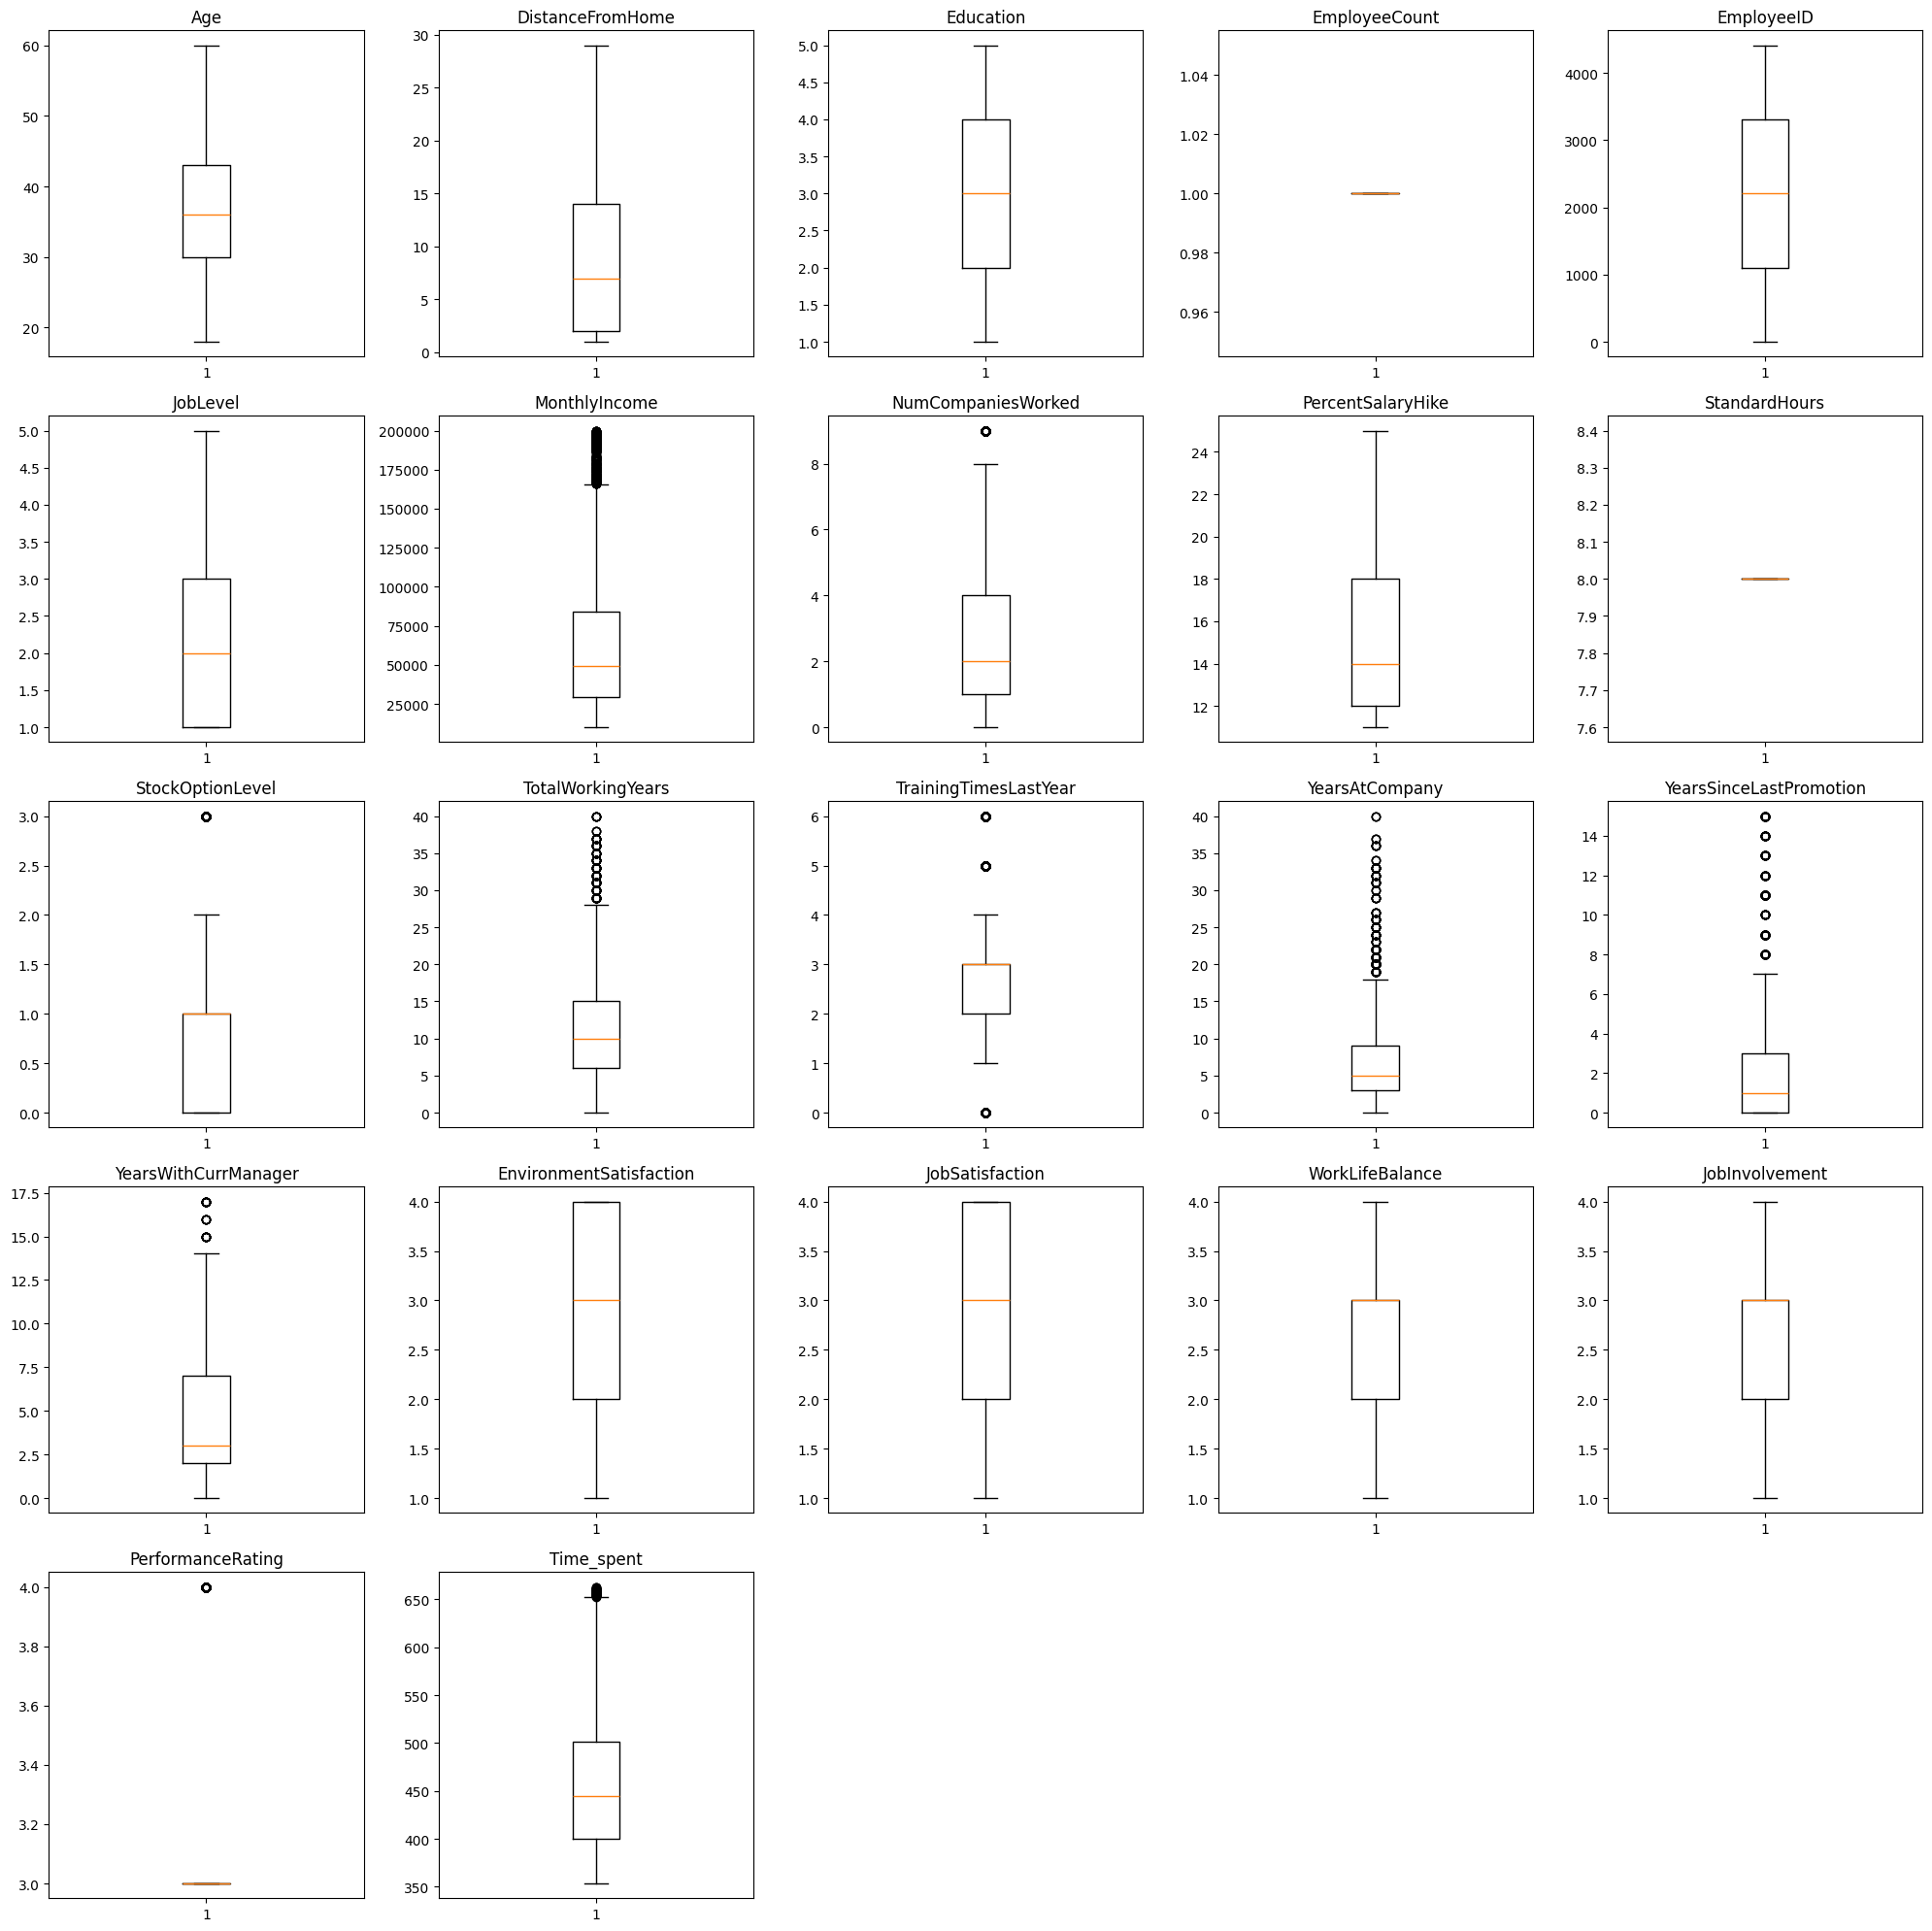

In [14]:
import matplotlib.pyplot as plt

def box_plot_multiple(columns, data, plots_per_row=3):
    """
    Affiche plusieurs boxplots sur une seule page.
    
    Args:
        *columns (list): Liste des colonnes pour lesquelles tracer les boxplots.
        *data (DataFrame): Données contenant les colonnes.
        *plots_per_row (int): Nombre de boxplots à afficher par ligne.
    """
    num_plots = len(columns)
    rows = (num_plots + plots_per_row - 1) // plots_per_row  # Calcul du nombre de lignes nécessaires
    
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(plots_per_row * 4, rows * 4))
    axes = axes.flatten()  # Aplatir les axes pour itération facile
    
    for i, col in enumerate(columns):
        axes[i].set_title(col)
        axes[i].boxplot(data[col])
    
    # Supprimer les sous-graphiques inutilisés si le nombre de colonnes est inférieur au nombre de sous-graphiques
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

box_plot_multiple(columns=numerical_data, data=gen_data_new, plots_per_row=5)

In [15]:
gen_data_new["EmployeeCount"].value_counts()

EmployeeCount
1    4410
Name: count, dtype: int64

In [16]:
gen_data_new["StandardHours"].value_counts()

StandardHours
8    4410
Name: count, dtype: int64

Il ne semble pas y avoir de valeurs aberrantes sérieuses car toutes les cases ont une hauteur clairement visible. Neanmoins notre avons remarque que **les variables EmployedID, StandHours, EmployedCount** ne sont pas tres pertinantes pour notre analyse car elles ont soit qu'une seule valeur, soit un seule valeur disctincte(cas de **EmployedID**), nous pourrons dont les supprimes par la suite

Nous allons egalement analyser nos donnees categorielle en utilisant des graphiques en barre :

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_bar_multiple(columns, data, plots_per_row=5):
    """
    Affiche plusieurs diagrammes en barres sur une seule page.
    
    Args:
        columns (list): Liste des colonnes à tracer.
        data (DataFrame): Données contenant les colonnes.
        plots_per_row (int): Nombre de diagrammes en barres par ligne.
    """
    num_plots = len(columns)
    rows = (num_plots + plots_per_row - 1) // plots_per_row  # Calcul du nombre de lignes nécessaires
    
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(plots_per_row * 5, rows * 5))
    axes = axes.flatten()  # Aplatir les axes pour une itération facile
    
    for i, col in enumerate(columns):
        data[col].value_counts().plot(kind='bar', ax=axes[i], color='skyblue')
        axes[i].set_title(f'Plot for {col} Employee Counts')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Employee Counts')
    
    # Supprimer les sous-graphiques inutilisés si le nombre de colonnes est inférieur au nombre de sous-graphiques
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()


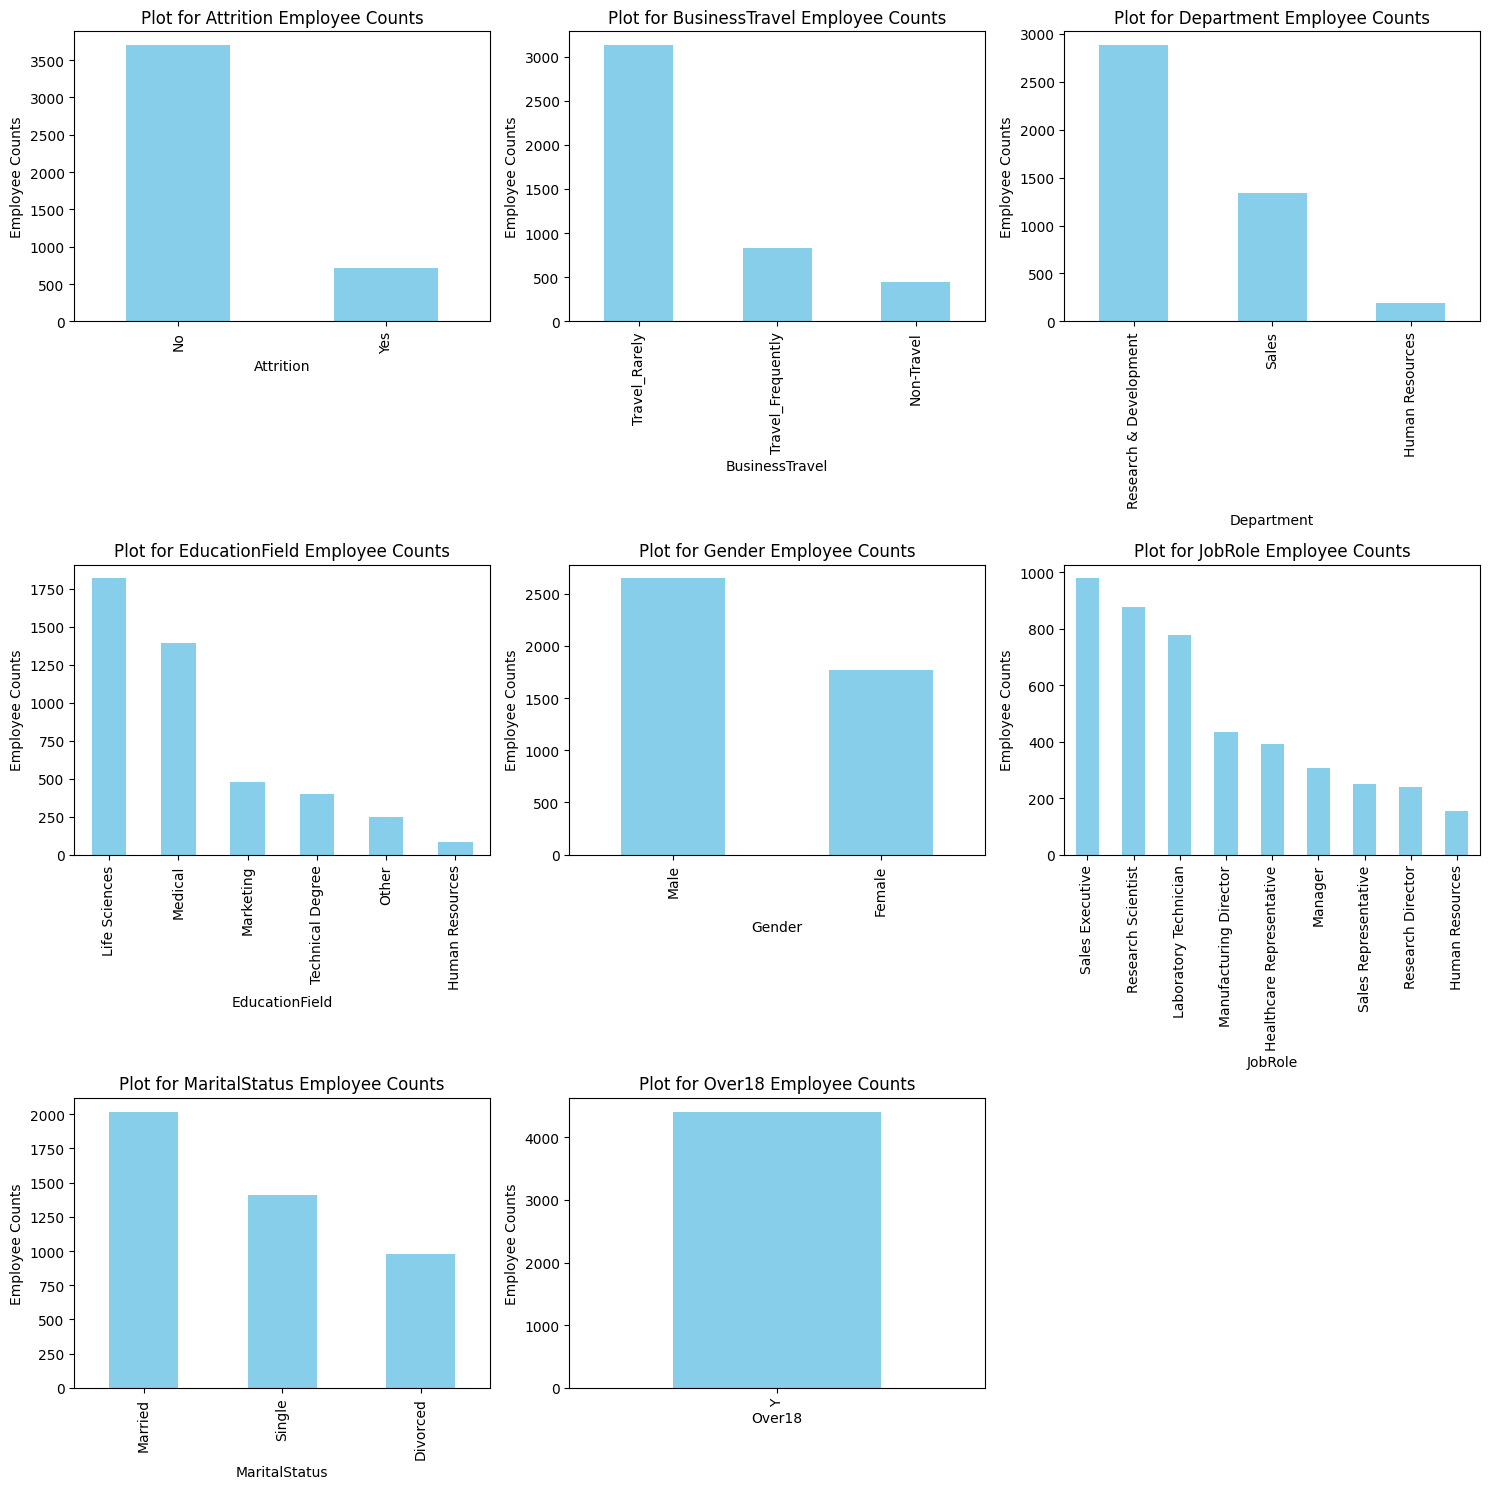

In [18]:
plot_bar_multiple(columns=categorical_data, data=gen_data_new, plots_per_row=3)

Comme pour l'analyse des donnees numeriques, nous remarquons la variable **Over18** n'a qu'une valeur unique, nous pouvons dont la retirer afin de traiter uniquement les variables pertinantes pour notre model de prediction.

En resume, nous allons retirer les variables  **EmployedID, StandHours, EmployedCount, Over18** de la modelisation car elles n'ont qu'une seule **valeur distincte ou des valeurs uniques**

In [19]:
gen_data_new.drop(['EmployeeID'],axis =1,inplace=True, errors='ignore')
gen_data_new.drop(['StandardHours'],axis =1,inplace=True, errors='ignore')
gen_data_new.drop(['EmployeeCount'],axis =1,inplace=True, errors='ignore')
gen_data_new.drop(['Over18'],axis =1,inplace=True, errors='ignore')

In [20]:
categorical_data = gen_data_new.select_dtypes(include=['object']).columns.tolist()

In [21]:
print(categorical_data)

['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']


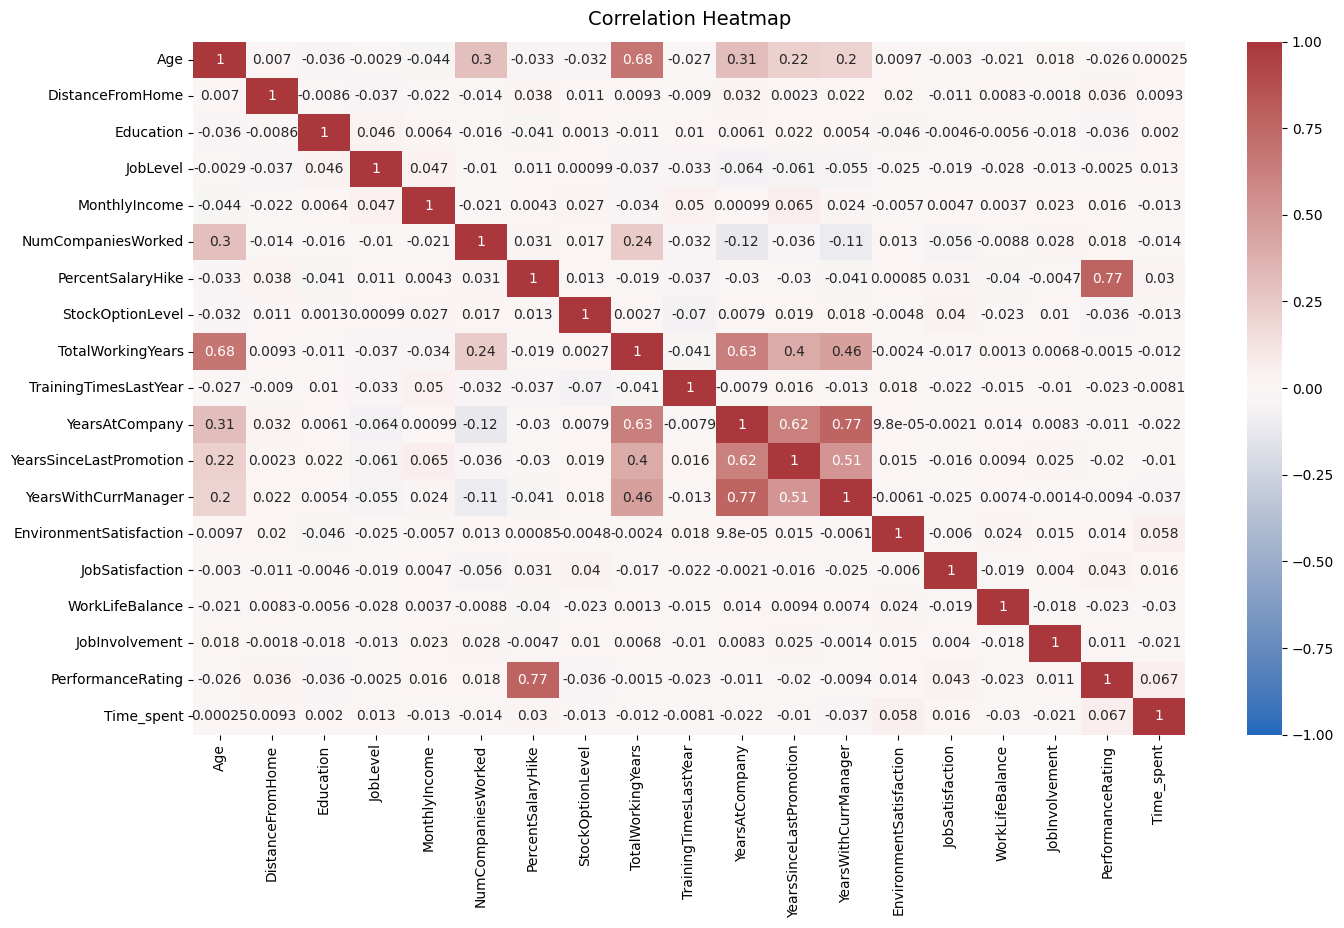

In [22]:
# Create a plot as needed 

# Plot a correlation heatmap
plt.figure(figsize=(16, 9))

#Remove non numeric columns
numeric_df = gen_data_new.select_dtypes(include=['float64', 'int64'])

heatmap = sns.heatmap(numeric_df.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

Nous allons ensuite encodé le reste de nos donnees de type categorielle en valeur binaire pour notre future modele de prediction :

In [23]:
from sklearn.preprocessing import LabelEncoder

scale = LabelEncoder()

for i in categorical_data:
    gen_data_new[i] = scale.fit_transform(gen_data_new[i])

gen_data_new.head(5)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Time_spent
0,51,0,2,2,6,2,1,0,1,0,...,6,1,0,0,3.0,4.0,2.0,3,3,441.398467
1,31,1,1,1,10,1,1,0,1,6,...,3,5,1,4,3.0,2.0,4.0,2,4,465.356322
2,32,0,1,1,17,4,4,1,4,7,...,2,5,0,3,2.0,2.0,1.0,3,3,419.440613
3,38,0,0,1,2,5,1,1,3,1,...,5,8,7,5,4.0,4.0,3.0,2,3,432.444444
4,32,0,2,1,10,1,3,1,1,7,...,2,6,0,4,4.0,1.0,3.0,3,3,480.536398


# Mise en place des modèles

Notre objectif est de prédire si un employé quitte l'entreprise, ce qui est une variable de résultat catégorique. Cette tâche implique donc une classification. Plus précisément, cela implique une classification binaire, puisque la variable de résultat laissée peut être soit 1 (indiquant que l'employé a quitté) ou 0 (indiquant que l'employé n'est pas parti).
Étant donné que la variable que nous souhaitons prédire (si un employé quitte l'entreprise) est catégorielle, nous avons choisit de créer un modèle de régression logistique et un modèle d'apprentissage automatique basé sur un arbre . Nous les comparerons ensuite.

## Régression Logistique

c:\Users\PC Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


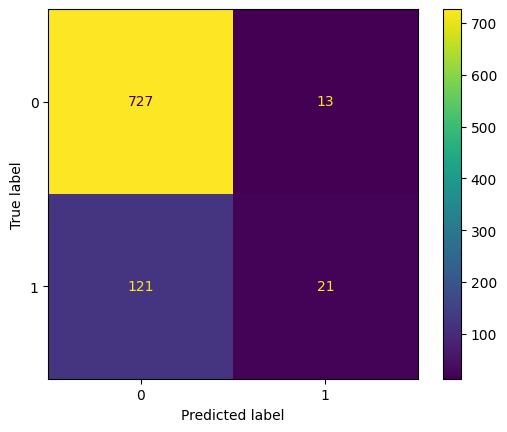

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.98      0.92       740
    Predicted would leave       0.62      0.15      0.24       142

                 accuracy                           0.85       882
                macro avg       0.74      0.57      0.58       882
             weighted avg       0.82      0.85      0.81       882

AUC-ROC (Régression Logistique): 0.7682908260373048


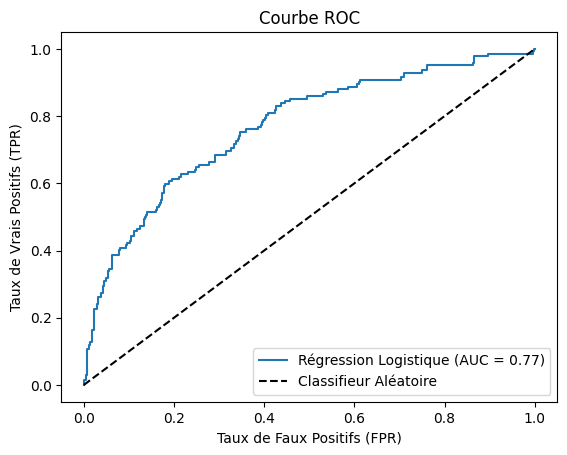

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Isolate the outcome variable
y = gen_data_new['Attrition']

# Select the features you want to use in your model
X = gen_data_new.drop('Attrition', axis=1)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

# Predict classes and probabilities on the test set
y_pred = log_clf.predict(X_test)
y_proba = log_clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Display confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)
log_disp.plot(values_format='d')
plt.show()

# Create classification report
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

# AUC-ROC score
roc_auc_log_reg = roc_auc_score(y_test, y_proba)
print("AUC-ROC (Régression Logistique):", roc_auc_log_reg)

# Courbe ROC
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_proba)
plt.plot(fpr_log_reg, tpr_log_reg, label=f"Régression Logistique (AUC = {roc_auc_log_reg:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Classifieur Aléatoire")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.show()

### Interpretation de la matrice et du rapport de classification:**


Le quadrant supérieur gauche affiche le nombre de vrais négatifs. Le quadrant supérieur droit affiche le nombre de faux positifs. Le quadrant inférieur gauche affiche le nombre de faux négatifs. Le quadrant inférieur droit affiche le nombre de vrais positifs.

•  Vrai négatif (VN) : 727 (cas où le modèle a correctement prédit « ne partirait pas »)

•  Faux positif (FP) : 13 (cas où le modèle a prédit à tort « partirait »)

•  Faux Négatif (FN) : 121 (cas où le modèle a prédit à tort « ne partirait pas »)

•  Vrai positif (TP) : 21 (cas où le modèle a correctement prédit « partirait »)


**Haut Taux de Vrais Négatifs**: Le modèle est très bon pour prédire les cas où l'événement "ne partirait pas" se produirait effectivement. C'est indiqué par la haute précision et le rappel pour cette classe.

**Faible Taux de Vrais Positifs**: Cependant, le modèle a du mal à prédire correctement les cas où l'événement "partirait" se produirait. La précision et le rappel pour cette classe sont bas.

**Exactitude Générale**: Avec une exactitude de 0.85, le modèle fait un travail raisonnable dans l'ensemble, mais les déséquilibres dans la précision et le rappel montrent qu'il y a place pour amélioration.

L'amélioration du rappel pour la classe « qui partirait » pourrait améliorer l' utilité du modèle , en particulier s'il est essentiel de prédire avec précision la classe « qui partirait » dans notre contexte .

### AUC (aire sous la courbe)
L'AUC de notre modèle est de 0.77, ce qui indique une bonne capacité de discrimination entre les classes. Plus l'AUC est proche de 1, meilleure est la performance du modèle pour distinguer entre les classes positives et négatives.

Recommandations pour l'Amélioration

•    Équilibrage des Classes: Utilisation des techniques comme l'ajustement des poids de classe ou l'échantillonnage pour équilibrer les données.

•    Algorithmes Alternatifs: Essais d'autres modèles de classification qui peuvent mieux gérer l'imbalance des classes.

•    Amélioration de l'Entraînement: Augmentation la quantité de données d'entraînement pour la classe minoritaire ou utilisez des techniques de sur-échantillonnage.

Vu que notre modele n'est pas mal de façon général. Evaluons sa capacité à s'adapter avec la **Cross Validation**.

La validation croisée permet d'obtenir une estimation plus fiable de la performance de votre modèle en utilisant plusieurs sous-échantillons des données. Cela réduit la dépendance à une seule division aléatoire des données d'entraînement et de test.

In [25]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


cv_accuracy_scores = cross_val_score(log_clf, X, y, cv=cv, scoring='accuracy')

cv_auc_scores = cross_val_score(log_clf, X, y, cv=cv, scoring='roc_auc')


print("Cross-validation accuracy scores:", cv_accuracy_scores)
print("Mean accuracy:", cv_accuracy_scores.mean())
print("Standard deviation of accuracy:", cv_accuracy_scores.std())

print("Cross-validation AUC-ROC scores:", cv_auc_scores)
print("Mean AUC-ROC:", cv_auc_scores.mean())
print("Standard deviation of AUC-ROC:", cv_auc_scores.std())

c:\Users\PC Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\PC Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Cross-validation accuracy scores: [0.86054422 0.84807256 0.85260771 0.85147392 0.84353741]
Mean accuracy: 0.8512471655328799
Standard deviation of accuracy: 0.005618826164790839
Cross-validation AUC-ROC scores: [0.79539399 0.75276932 0.79159688 0.80624286 0.76238917]
Mean AUC-ROC: 0.7816784424577596
Standard deviation of AUC-ROC: 0.020482752853241804


c:\Users\PC Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\PC Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

### Analyse de la Précision

**Scores Consistants**: Les scores de précision sont tous très proches les uns des autres, ce qui montre que notre modèle est stable et performant de manière cohérente à travers les différentes partitions des données.

**Précision Élevée**: Une précision moyenne de 0.8512 indique que notre modèle est capable de prédire correctement environ 85% du temps en moyenne.

**Faible Variabilité**: L'écart-type de 0.0056 est faible, ce qui signifie que la performance du modèle ne varie pas beaucoup selon les différentes divisions des données, ce qui est un bon signe de robustesse.

## Conclusion
Notre modèle de régression logistique montre une bonne performance générale avec une précision moyenne élevée et une AUC-ROC moyenne solide. La faible variabilité dans les scores de précision et une AUC-ROC globalement stable renforcent la fiabilité de votre modèle.

## Decision Trees (Arbre de Décision)



### Construction d'un modèle d'arbre de décision

Construire un modèle d'arbre de décision et mettre en place une grille de recherche à validation croisée pour rechercher de manière exhaustive les meilleurs paramètres du modèle.

In [26]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Dictionnaire des scores
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

tree1.fit(X_train, y_train)

# Vérifier le meilleur score AUC sur le CV
tree1.best_score_
print("Le Meilleure score AUC :", tree1.best_score_)


Le Meilleure score AUC : 0.9116228402989395


Il s'agit d'un score AUC élevé, qui montre que ce modèle peut très bien prédire les employés qui partiront.

Ensuite, nous avons écrire une fonction qui nous a aider à extraire tous les scores de la grille de recherche. 

In [27]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.81704,0.794433,0.804994,0.937925,0.911623


Tous ces résultats du modèle d'arbre décisionnel sont de bons indicateurs de la performance du modèle. 

Rappelons que les arbres de décision peuvent être vulnérables au surajustement. Nous tenterons de l'ameliorer en utilisant "features engeneering

Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 6}
Meilleur score roc_auc : 0.9116228402989395


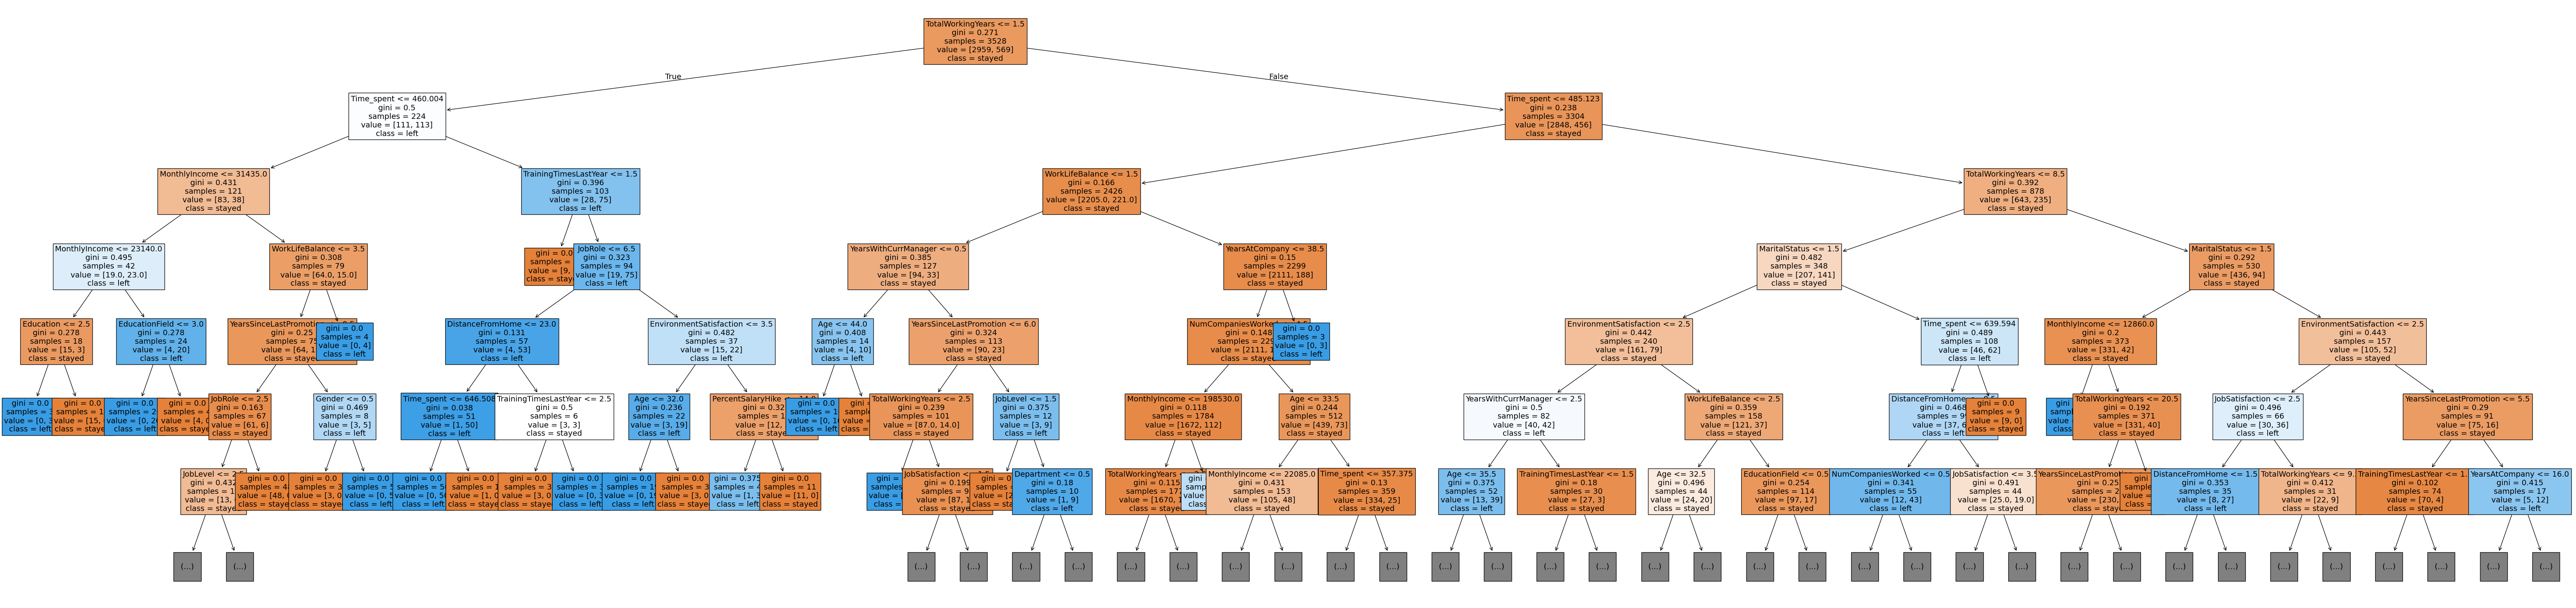

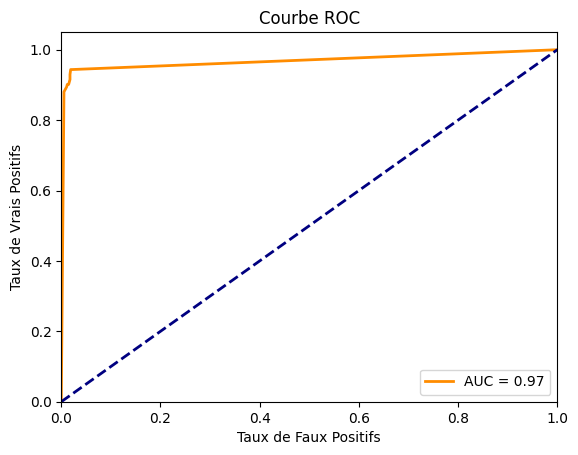

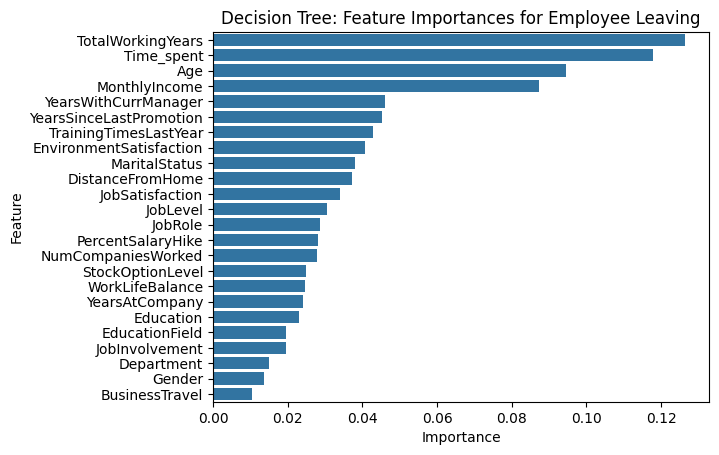

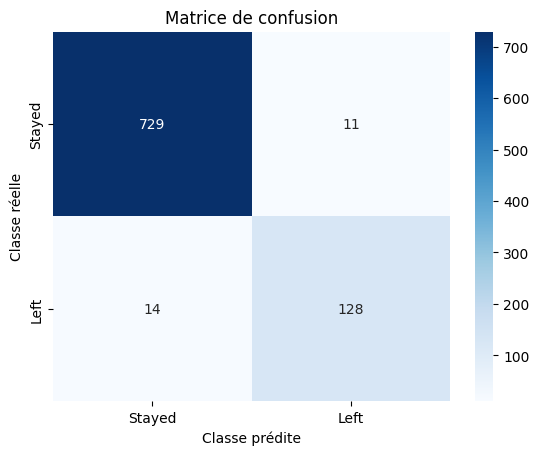

Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       740
           1       0.92      0.90      0.91       142

    accuracy                           0.97       882
   macro avg       0.95      0.94      0.95       882
weighted avg       0.97      0.97      0.97       882



In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Dictionnaire des scores
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Instantiate GridSearch
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

tree2.fit(X_train, y_train)

# Accéder aux meilleurs paramètres
print("Meilleurs paramètres :", tree2.best_params_)

# Accéder au meilleur score pour la métrique refit
print("Meilleur score roc_auc :", tree2.best_score_)

# Plot the tree
plt.figure(figsize=(85, 20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns,
          class_names={0: 'stayed', 1: 'left'}, filled=True)
plt.show()

# Calculer la courbe ROC
# Prédictions de probabilité pour chaque classe
y_pred_proba = tree2.best_estimator_.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

# Importance des features
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_,
                                 columns=['gini_importance'],
                                 index=X.columns
                                 )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]

# Afficher l'importance des features
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

# Calculer les prédictions finales
y_pred = tree2.best_estimator_.predict(X_test)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
plt.title("Matrice de confusion")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

# Afficher le rapport de classification
print("Rapport de classification :\n", classification_report(y_test, y_pred))


### Interpretation de la matrice et du rapport de classification:**

. True Negative (TN): 729 (les cas où le modèle a correctement prédit "ne partirait pas").

. False Positive (FP): 11 (les cas où le modèle a incorrectement prédit "partirait" mais en réalité "ne partirait pas").

. False Negative (FN): 14 (les cas où le modèle a incorrectement prédit "ne partirait pas" mais en réalité "partirait").

. True Positive (TP): 128 (les cas où le modèle a correctement prédit "partirait").

**Interprétation des Résultats**

. Haute Exactitude: La majorité des prédictions sont correctes, comme le montrent les valeurs élevées de TN et TP.

. Faible Taux de Faux Positifs et Faux Négatifs: Les valeurs de FP et FN sont faibles, ce qui indique que le modèle fait peu d'erreurs.

. Performance Générale: Le modèle semble être bien équilibré avec une bonne capacité à discriminer entre les classes "partirait" et "ne  partirait pas".

 **Analyse des Résultats de rapport de classification** :

- Haute Précision et Rappel pour la Classe 0: Le modèle est très performant pour prédire les cas où les individus ne partiraient pas, avec des valeurs de précision et de rappel proches de 1.

- Bonne Précision et Rappel pour la Classe 1: Bien que légèrement inférieurs à ceux de la classe 0, les scores pour la classe 1 sont toujours élevés, indiquant une bonne capacité du modèle à prédire les départs.

- Équilibre entre les Classes: La macro moyenne et la moyenne pondérée montrent que le modèle maintient un bon équilibre entre les prédictions des deux classes.

Exactitude Globale: Une exactitude de 97% indique que le modèle est globalement fiable et performant.

### AUC (aire sous la courbe)

La courbe ROC (Receiver Operating Characteristic) que vous avez fournie montre la performance du modèle en termes de discrimination entre les classes positives et négatives. L'AUC (Area Under the Curve) est de 0.97, ce qui est très élevé et indique une excellente performance globale du modèle pour différencier entre les classes.

## Interpretation du diagramme de barre

Le diagramme à barres ci-dessus montre que dans ce modèle d'arbre de décision, `TotalWorkingYears`, `Time_spent`, `Age` et `MonthlyIncome` ont la plus grande importance, dans cet ordre. Ces variables sont les plus utiles pour prédire la variable de résultat de l'attrition.

In [29]:
from sklearn.model_selection import cross_val_score

# Validation croisée pour évaluer le modèle avec les meilleurs hyperparamètres
best_model = tree2.best_estimator_

# Effectuer la validation croisée
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')  # Utiliser la métrique souhaitée

# Afficher les scores de la validation croisée
print("Scores de validation croisée (Accuracy) :", cv_scores)
print("Moyenne des scores :", np.mean(cv_scores))
print("Écart-type des scores :", np.std(cv_scores))


Scores de validation croisée (Accuracy) : [0.93342776 0.94617564 0.94050992 0.93617021 0.95744681]
Moyenne des scores : 0.9427460671448376
Écart-type des scores : 0.008519938919891881


## Conclusion

Haute Précision: Le modèle montre une précision élevée de manière constante à travers les différents ensembles de données utilisés dans la validation croisée.

Stabilité et Robustesse: La faible variabilité entre les scores des différents plis (indiquée par l'écart-type faible) montre que le modèle n'est pas sensible à la partition des données et qu'il peut être considéré comme fiable et robuste.

La validation croisée confirme donc que votre modèle de régression logistique fonctionne bien et de manière cohérente sur les données.